In [1]:
import uproot
import awkward as ak
import mplhep
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import scipy.integrate as integrate
from scipy.optimize import curve_fit

## Data Import

In [2]:
path_data="data_z0experiment-main/data/daten_1.root"
file = uproot.open(path_data)
ttree = 'myTTree'
data_branches = file[ttree].arrays()
#ee_ctrk = ak.to_numpy(ee_branches.Ncharged)
#file[ttree].keys()

data_ctrk = ak.to_numpy(data_branches.Ncharged)
data_sump = ak.to_numpy(data_branches.Pcharged)
data_ecal = ak.to_numpy(data_branches.E_ecal)
data_hcal = ak.to_numpy(data_branches.E_hcal)
data_cos = ak.to_numpy(data_branches.cos_thet)
data_elep = ak.to_numpy(data_branches.E_lep)

In [3]:
#with open('data_z0experiment-main/lumi_files/daten_1.lum') as f:
#    lines = f.readlines()
#print(lines)

In [4]:
lumi_matrix = np.array([[88.48021,675.8590,3.502185,4.524100,5.721257],[89.47158,543.6270,3.179205,3.637000,4.830643],[90.22720,419.7760,2.810879,2.810400,3.974844],[91.23223,3122.204,7.786547,20.91518,22.31760],[91.97109,639.8380,3.567344,4.287300,5.577354],[92.97091,479.2400,3.121618,3.216000,4.481870],[93.71841,766.8380,3.972102,5.142000,6.497519]])
#print(lumi_matrix)

## Exercise 3

In [5]:
def particleID(ctrk,sump,ecal,hcal,details=False):
    had_count =0
    e_count = 0
    m_count = 0
    tau_count = 0
    
    if (8 <= ctrk <= 38): had_count += 1*3
    if (0 <= ctrk <= 4): e_count += 1
    if (2 <= ctrk <= 3): m_count += 1 * 2
    if (2 <= ctrk <= 7): tau_count += 1 * 2
        
    if (0 <= sump <= 80): had_count += 1
    if (0 <= sump <= 1) or (20 <= sump <= 1000): e_count += 1
    if (0 <= sump <= 1) or (70 <= sump <= 1000): m_count += 1 * 1.5
    if (5 <= sump <= 70): tau_count += 1 * 1.5
        
    if (20 <= ecal <= 90): had_count += 1 
    if (70 <= ecal <= 1000): e_count += 1 * 2
    if (1 <= ecal <= 11): m_count += 1
    if (11 <= ecal <= 75): tau_count += 1 
        
    if (3 <= hcal <= 50): had_count += 1
    if (0 <= hcal <= 7): e_count += 1
    if (0 <= hcal <= 14): m_count += 1
    if (0 <= hcal <= 35): tau_count += 1
        
    
    if details:
        print("Hadronic:",had_count,"Electron:",e_count,"Muon:",m_count,"Tau:",tau_count)
        
    return [had_count,e_count,m_count,tau_count]

def array_ID(ctrk,sump,ecal,hcal):
    
    result = []
    for i in range(0,len(ctrk)):
        result.append(particleID(ctrk[i],sump[i],ecal[i],hcal[i]))
    return result

def particle_ID_1234(ctrk,sump,ecal,hcal):
    namelist = []
    spare_list = []
    particle_list = array_ID(ctrk,sump,ecal,hcal)
    for particle in particle_list:
        name = []
        indices = [i for i, x in enumerate(particle) if x == max(particle)]
        if 0 in indices:
            name = 1
        if 1 in indices:
            name = 2
        if 2 in indices:
            name = 3
        if 3 in indices:
            name = 4
        if len(indices) != 1:
            name=0
            spare_list.append(np.array(indices)+1)
        namelist.append(name)
    return [namelist,spare_list]

def eff(id_array,Errorcounter=False):
    results = np.array([0,0,0,0])
    errors = 0
    for particle in id_array:
        if particle != 0:
            results[particle-1] += 1
        else:
            errors += 1
    
    if Errorcounter:
        print(errors)
    return results

In [6]:
ID_array,spare_array = particle_ID_1234(data_ctrk,data_sump,data_ecal,data_hcal) 
ID_counted = eff(ID_array)

In [7]:
#Correction for t and s channel
ID_counted[1] *= 0.6807558707107277 

In [8]:
print("|  qq   |  ee  |  mm   |  tt  |")
print(ID_counted)
print("Number of non-identifiable particles:",len(spare_array),"overall event number:",len(data_ctrk),"ratio:",len(spare_array)/len(data_ctrk))

|  qq   |  ee  |  mm   |  tt  |
[138066  15321   6781   8173]
Number of non-identifiable particles: 356 overall event number: 175883 ratio: 0.0020240728211367784


## Inverse Matrix & and real number of events

Not used!

In [9]:
#np.linalg.inv

eff_matrix = np.array([[9.86881487e-01, 1.11603746e-04, 5.07289754e-05, 1.12415409e-02],
                       [9.59467815e-05, 9.70437731e-01, 1.06500927e-02, 1.80486557e-02],
                       [1.16548882e-04, 1.37739587e-04, 9.66614043e-01, 3.30998824e-02],
                       [0.00806676, 0.00409019, 0.008193,   0.97792057]])

mat_error = [[4.46027387e-03, 3.36516731e-05, 2.26872629e-05, 3.39612305e-04],
            [3.19835191e-05, 4.31063693e-03, 3.38422751e-04, 4.41883609e-04],
            [3.51425317e-05, 3.82043001e-05, 4.30872185e-03, 6.00387342e-04],
            [0.00031965, 0.00022743, 0.00032215, 0.00416919]]

inv_eff_matrix = np.linalg.inv(eff_matrix)

counted_events = np.matmul(inv_eff_matrix,ID_counted)
print("|       qq       |      ee        |     mm      |       tt       |")
print(counted_events)
print("Amount of events prior of matrix calc:",np.sum(ID_counted),"and after matrix mult.:", np.sum(counted_events),"ratio:",np.sum(counted_events)/np.sum(ID_counted))

|       qq       |      ee        |     mm      |       tt       |
[139818.51286265  15568.05603671   6753.6061116    7082.48627103]
Amount of events prior of matrix calc: 168341 and after matrix mult.: 169222.66128199134 ratio: 1.0052373532412862


In [10]:
from scipy.optimize import curve_fit

matrix = eff_matrix
matrix_inv= np.linalg.inv(matrix)
error_matrix = np.array(mat_error)


### Number of toy experiments to be done
ntoy = 10000

### Create numpy matrix of list to append elements of inverted toy matrices
inverse_toys = np.empty((4,4))

# Create toy efficiency matrix out of gaussian-distributed random values
for i in range(0,ntoy,1):
    toy_matrix = np.zeros((4,4))
    toy_matrix = np.random.normal(matrix,error_matrix,size=(4,4))
    
    ### Invert toy matrix
    inverse_toy = np.linalg.inv(toy_matrix)
    
    #print(inverse_toys.item(0,0),inverse_toy.item(0,0))
    # Append values
    inverse_toys = np.dstack((inverse_toys,inverse_toy))

Erros for the inverse matrix:
[[4.59879683e-03 3.49285017e-05 2.42066214e-05 3.54879151e-04]
 [3.40307723e-05 4.76386767e-03 3.73829225e-04 4.79070201e-04]
 [3.89917220e-05 4.12866636e-05 4.61310252e-03 6.68039041e-04]
 [3.33146985e-04 2.43665133e-04 3.47190165e-04 4.35432140e-03]]


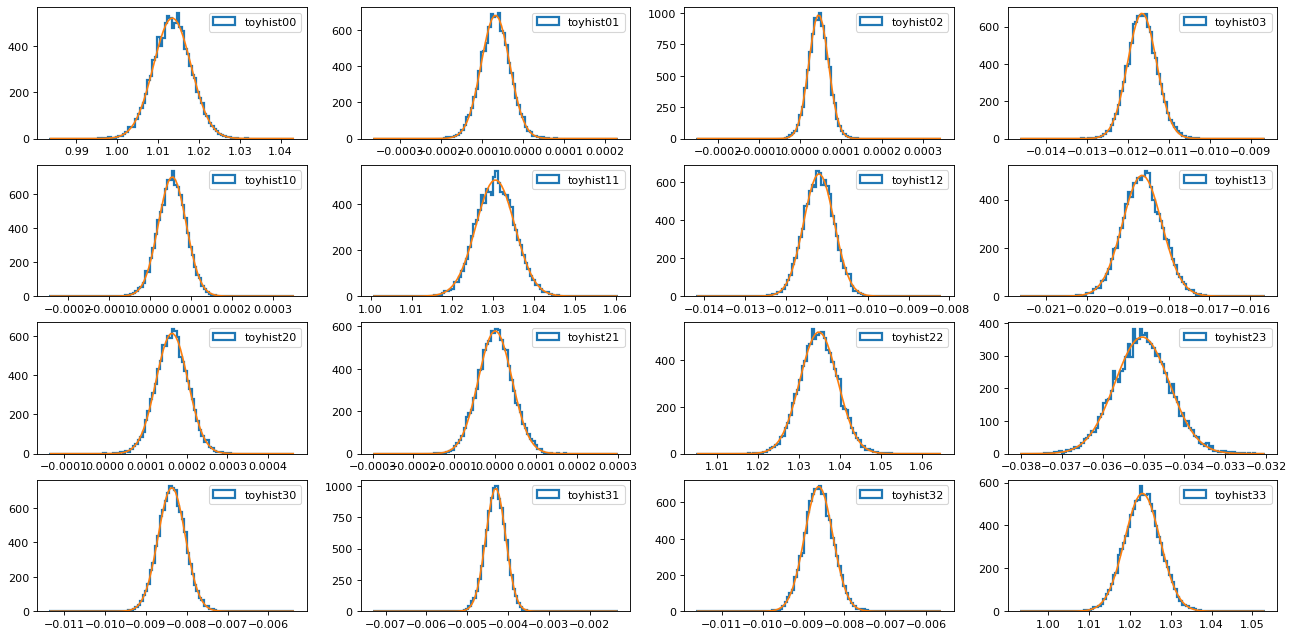

In [11]:
# Define gaussian function to fit to the toy distributions:
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))


inverse_errors = np.zeros((4,4))
inverse_means = np.zeros((4,4))


fig = plt.figure(figsize=(20, 10),dpi=80)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.2)
ax00 = plt.subplot(4,4,1)
ax01 = plt.subplot(4,4,2)
ax02 = plt.subplot(4,4,3)
ax03 = plt.subplot(4,4,4)

ax10 = plt.subplot(4,4,5)
ax11 = plt.subplot(4,4,6)
ax12 = plt.subplot(4,4,7)
ax13 = plt.subplot(4,4,8)

ax20 = plt.subplot(4,4,9)
ax21 = plt.subplot(4,4,10)
ax22 = plt.subplot(4,4,11)
ax23 = plt.subplot(4,4,12)

ax30 = plt.subplot(4,4,13)
ax31 = plt.subplot(4,4,14)
ax32 = plt.subplot(4,4,15)
ax33 = plt.subplot(4,4,16)

axes = [[ax00,ax01,ax02,ax03],
        [ax10,ax11,ax12,ax13],
        [ax20,ax21,ax22,ax23],
        [ax30,ax31,ax32,ax33]]
dx=0.03
dx1=0.003
dx2=0.0003
## IMPORTANT! Find suitable ranges to fit/plot gaussian distributions successfully!
ranges = [[(matrix_inv[0][0]-dx,matrix_inv[0][0]+dx),(matrix_inv[0][1]-dx2,matrix_inv[0][1]+dx2), (matrix_inv[0][2]-dx2,matrix_inv[0][2]+dx2), (matrix_inv[0][3]-dx1,matrix_inv[0][3]+dx1)],
          [(matrix_inv[1][0]-dx2,matrix_inv[1][0]+dx2),(matrix_inv[1][1]-dx,matrix_inv[1][1]+dx), (matrix_inv[1][2]-dx1,matrix_inv[1][2]+dx1), (matrix_inv[1][3]-dx1,matrix_inv[1][3]+dx1)],
          [(matrix_inv[2][0]-dx2,matrix_inv[2][0]+dx2),(matrix_inv[2][1]-dx2,matrix_inv[2][1]+dx2), (matrix_inv[2][2]-dx,matrix_inv[2][2]+dx), (matrix_inv[2][3]-dx1,matrix_inv[2][3]+dx1)],
          [(matrix_inv[3][0]-dx1,matrix_inv[3][0]+dx1),(matrix_inv[3][1]-dx1,matrix_inv[3][1]+dx1), (matrix_inv[3][2]-dx1,matrix_inv[3][2]+dx1), (matrix_inv[3][3]-dx,matrix_inv[3][3]+dx)]]


# Fill histograms for each inverted matrix coefficient:
for j in range(0,4,1):
    for k in range(0,4,1):
        
        # Diagonal and off-diagonal terms have different histogram ranges
        hbins, hedges, _ = axes[j][k].hist(inverse_toys[j,k,:],bins=100,range=ranges[j][k],  histtype='step', linewidth=2, label=f'toyhist{j}{k}')
        axes[j][k].legend()

        ## Guess initial parameters of the fit by taking random value from hist and std
        _p0 = [ntoy/10.,np.std(inverse_toys[j,k,:]),np.std(inverse_toys[j,k,:])]
        if j==k:
            sig=dx
        else:
            sig=dx2
            
        # Get the fitted curve
        h_mid = 0.5*(hedges[1:] + hedges[:-1]) #Calculate midpoints for the fit
        coeffs, _ = curve_fit(gauss, h_mid, hbins, p0=[600,matrix_inv[j][k],sig], maxfev=100000)
        h_fit = gauss(h_mid, *coeffs)
        
        axes[j][k].plot(h_mid, h_fit,label=f'Fit{j}{k}')

        inverse_means[j,k] = coeffs[1]
        inverse_errors[j,k] = abs(coeffs[2])

print(f"Erros for the inverse matrix:\n{inverse_errors}")

In [12]:
error_counted = np.matmul(inverse_errors,ID_counted)
print("The errors (absolute) on the counted events:",error_counted)

The errors (absolute) on the counted events: [638.5371951   84.13608595  42.75731531  87.67163048]


## Getting the individual cross sections

First try: fit a breit wigner + x^2, didnt work, to few points and complicated equation. Then: Whats the closest energy? Take over this luminosity.

In [13]:
lumi_liste = []
energy_list = []
for element in data_elep*2:
    dist = np.abs(lumi_matrix[:,0] - element)
    #print(dist,element)
    indices = [i for i, x in enumerate(dist) if x == min(dist)]
    lumi_liste.append(lumi_matrix[indices[0],1])
    energy_list.append(lumi_matrix[indices[0],0])

In [14]:
for element in data_elep[:10000:100]*2:
    dist = np.abs(lumi_matrix[:,0] - element)
    #print(dist,element)
    indices = [i for i, x in enumerate(dist) if x == min(dist)]
    print(dist)
    print(min(dist))
    #print(lumi_matrix[indices[0],1])
    #print(lumi_matrix[indices[0],0])
    print("__________________________")

[2.77478725 1.78341725 1.02779725 0.02276725 0.71609275 1.71591275
 2.46341275]
0.02276725341796748
__________________________
[2.77679378 1.78542378 1.02980378 0.02477378 0.71408622 1.71390622
 2.46140622]
0.02477378417968623
__________________________
[2.77679378 1.78542378 1.02980378 0.02477378 0.71408622 1.71390622
 2.46140622]
0.02477378417968623
__________________________
[2.77679378 1.78542378 1.02980378 0.02477378 0.71408622 1.71390622
 2.46140622]
0.02477378417968623
__________________________
[2.77679378 1.78542378 1.02980378 0.02477378 0.71408622 1.71390622
 2.46140622]
0.02477378417968623
__________________________
[2.77679378 1.78542378 1.02980378 0.02477378 0.71408622 1.71390622
 2.46140622]
0.02477378417968623
__________________________
[2.77679378 1.78542378 1.02980378 0.02477378 0.71408622 1.71390622
 2.46140622]
0.02477378417968623
__________________________
[2.77679378 1.78542378 1.02980378 0.02477378 0.71408622 1.71390622
 2.46140622]
0.02477378417968623
___________

In [15]:
qq_events = np.array([0,0,0,0,0,0,0])
ee_events = np.array([0,0,0,0,0,0,0])
mm_events = np.array([0,0,0,0,0,0,0])
tt_events = np.array([0,0,0,0,0,0,0])


for number in range(0,len(ID_array)):
    if ID_array[number] == 1:
        #print(lumi_liste[number])
        index = [i for i in range(len(lumi_matrix[:,1])) if lumi_matrix[i,1] == lumi_liste[number]]
        qq_events[index[0]] += 1
    elif ID_array[number] == 2:
        #print(lumi_liste[number])
        index = [i for i in range(len(lumi_matrix[:,1])) if lumi_matrix[i,1] == lumi_liste[number]]
        ee_events[index[0]] += 1
    elif ID_array[number] == 3:
        #print(lumi_liste[number])
        index = [i for i in range(len(lumi_matrix[:,1])) if lumi_matrix[i,1] == lumi_liste[number]]
        mm_events[index[0]] += 1
    elif ID_array[number] == 4:
        #print(lumi_liste[number])
        index = [i for i in range(len(lumi_matrix[:,1])) if lumi_matrix[i,1] == lumi_liste[number]]
        tt_events[index[0]] += 1
        

print("qq",qq_events)
print("ee",ee_events)
print("mm",mm_events)
print("tt",tt_events)

qq [ 3521  5315  7518 92445 15249  6619  7399]
ee [ 2177  1877  1464 11929  1970  1225  1865]
mm [ 190  297  375 4452  771  320  376]
tt [ 287  349  401 5357  904  416  459]


In [16]:
#energy_events_matrix = np.array([qq_events,ee_events* 0.6807558707107277 ,mm_events,tt_events])
#energy_events_matrix = np.array([qq_events,ee_events* 0.8200985942211408 ,mm_events,tt_events])
energy_events_matrix = np.array([qq_events,ee_events ,mm_events,tt_events])

eff_energy_events_matrix = np.matmul(inv_eff_matrix,energy_events_matrix)
error_energy_events_matrix = np.matmul(inverse_errors,energy_events_matrix)
print("Event matrix after effiecny correction:\n",eff_energy_events_matrix)
print("qq:",eff_energy_events_matrix[0])

Event matrix after effiecny correction:
 [[ 3564.65810482  5381.97930857  7613.89902844 93619.65956771
  15442.52705863  6702.70193818  7492.60316587]
 [ 2236.20300573  1924.78230984  1497.44325442 12148.58430588
   2005.50117887  1251.43156446  1909.592215  ]
 [  187.14516603   295.99505302   375.25201611  4434.62333014
    768.69695831   317.66290587   374.23598286]
 [  253.15448991   301.95402452   337.84056376  4617.7265583
    782.19852291   362.20703186   396.43532408]]
qq: [ 3564.65810482  5381.97930857  7613.89902844 93619.65956771
 15442.52705863  6702.70193818  7492.60316587]


In [17]:
cross_matrix = eff_energy_events_matrix / lumi_matrix[:,1]

Our equation:
$$\sigma = \frac{N}{L}$$
By using gaussian error propagation:
$$
\sigma_\sigma = \sqrt{\left(\frac{1}{L}\sigma_N\right)^2 + \left(\frac{N}{L^2}\sigma_L\right)^2}
$$

In [18]:
def error_prop(L,N,sN,sL):
    return np.sqrt((sN/L)**2 + (sL*N/L**2)**2)

error_cross = error_prop(lumi_matrix[:,1],eff_energy_events_matrix,error_energy_events_matrix,lumi_matrix[:,-1])
print("Error Matrix for corss section:\n",error_cross)
print("Cross section matrix:\n",cross_matrix)
#print(error_cross/cross_matrix)

Error Matrix for corss section:
 [[0.05079769 0.09896126 0.19068478 0.25434702 0.23751397 0.14558591
  0.09407702]
 [0.03217278 0.03590115 0.03828205 0.03458972 0.03197251 0.02781367
  0.02446592]
 [0.00302785 0.00595565 0.01015022 0.01359165 0.01291542 0.00754676
  0.00519121]
 [0.00547802 0.0086335  0.013618   0.02153479 0.01861277 0.01162999
  0.00790771]]
Cross section matrix:
 [[ 5.27426298  9.90013246 18.13800462 29.98511935 24.13505772 13.98610704
   9.77077709]
 [ 3.30868274  3.54063045  3.56724361  3.89102836  3.13438898  2.61128363
   2.49021595]
 [ 0.27689972  0.54448188  0.89393395  1.42035028  1.2013931   0.66284723
   0.48802483]
 [ 0.37456702  0.55544339  0.80481153  1.47899579  1.22249464  0.75579466
   0.51697402]]


In [19]:
xs_corrections = [[2.0, 4.3, 7.7, 10.8, 4.7, -0.2, -1.6],
                  [0.09, 0.20, 0.36, 0.52, 0.22, -0.01, -0.08]]
cross_matrix[0] += xs_corrections[0]
cross_matrix[1] += xs_corrections[1]
cross_matrix[2] += xs_corrections[1]
cross_matrix[3] += xs_corrections[1]

print("Matrix of cross section after corrections:\n",cross_matrix)

Matrix of cross section after corrections:
 [[ 7.27426298 14.20013246 25.83800462 40.78511935 28.83505772 13.78610704
   8.17077709]
 [ 3.39868274  3.74063045  3.92724361  4.41102836  3.35438898  2.60128363
   2.41021595]
 [ 0.36689972  0.74448188  1.25393395  1.94035028  1.4213931   0.65284723
   0.40802483]
 [ 0.46456702  0.75544339  1.16481153  1.99899579  1.44249464  0.74579466
   0.43697402]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


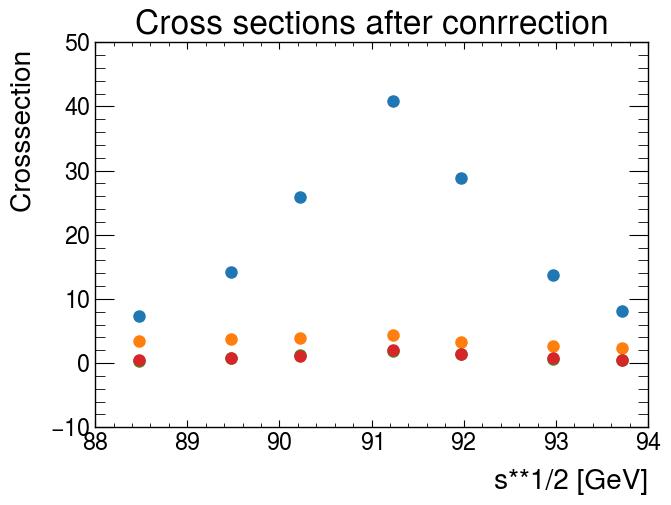

In [20]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

plt.plot(lumi_matrix[:,0],cross_matrix[0],ls="",marker="o")
plt.plot(lumi_matrix[:,0],cross_matrix[1],ls="",marker="o")
plt.plot(lumi_matrix[:,0],cross_matrix[2],ls="",marker="o")
plt.plot(lumi_matrix[:,0],cross_matrix[3],ls="",marker="o")

plt.title('Cross sections after conrrection')
#plt.xlim(0,2)
plt.xlabel('s**1/2 [GeV]')
plt.ylabel('Crosssection ')
#plt.ylim(0,20000)
plt.legend()
plt.show()

## Crosssection fit

In [32]:
def breit_wigner(x,a,b,c):
    return x*a * 1/((x-b)**2 + x**2*c**2)

popt = []
pcov = []
for i in range(0,4):
    case_popt,case_pcov = curve_fit(breit_wigner,lumi_matrix[:,0]**2,cross_matrix[i],sigma=error_cross[i],p0=[1,8200,1],maxfev=10000000)
    popt.append(case_popt)
    pcov.append(case_pcov)


In [33]:
print("_________________________________________________________")
print("Fit results:")
print("Event|       a       |       b       |       c      ")
print("qq: ",popt[0])
print("ee: ",popt[1])
print("mm: ",popt[2])
print("tt: ",popt[3])
print("_________________________________________________________")
print("Covarianc matricies:")
print("qq:\n",pcov[0])
print("ee:\n",pcov[1])
print("mm:\n",pcov[2])
print("tt:\n",pcov[3])
print("_________________________________________________________")
#print(popt[1][2]/popt[2][2],popt[1][2]/popt[3][2] )

_________________________________________________________
Fit results:
Event|       a       |       b       |       c      
qq:  [2.61263397e+02 8.31563717e+03 2.78278693e-02]
ee:  [2.26193793e+02 8.19443819e+03 8.16044682e-02]
mm:  [1.33229504e+01 8.31209843e+03 2.87507086e-02]
tt:  [1.58970907e+01 8.32022986e+03 3.21236614e-02]
_________________________________________________________
Covarianc matricies:
qq:
 [[6.77786771e+00 1.45172863e+00 4.94952022e-04]
 [1.45172863e+00 2.00744320e+00 9.28814602e-05]
 [4.94952022e-04 9.28814602e-05 4.63054766e-08]]
ee:
 [[ 2.83342870e+03 -7.57622613e+02  5.84217708e-01]
 [-7.57622613e+02  1.37736090e+03 -1.46867004e-01]
 [ 5.84217708e-01 -1.46867004e-01  1.23057165e-04]]
mm:
 [[8.31611476e-02 2.97760726e-01 1.22572437e-04]
 [2.97760726e-01 9.16354713e+00 3.78203338e-04]
 [1.22572437e-04 3.78203338e-04 2.27635974e-07]]
tt:
 [[2.33378046e+00 5.72354512e+00 3.28044386e-03]
 [5.72354512e+00 1.69110995e+02 6.21447554e-03]
 [3.28044386e-03 6.21447554e-

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


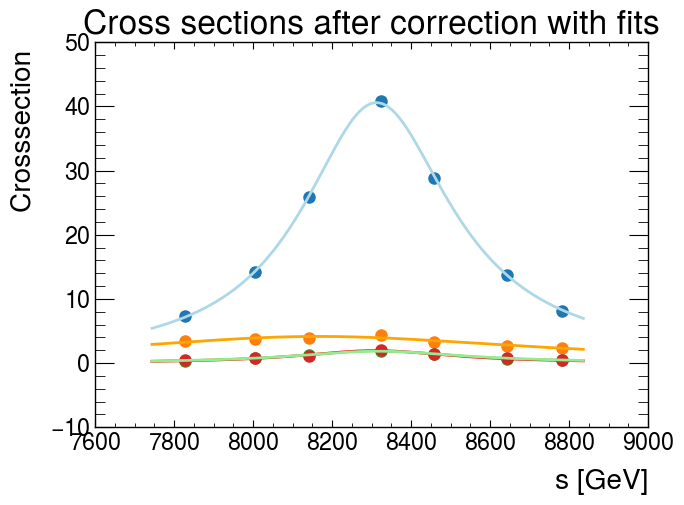

In [36]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

plt.plot(lumi_matrix[:,0]**2,cross_matrix[0],ls="",marker="o")
plt.plot(lumi_matrix[:,0]**2,cross_matrix[1],ls="",marker="o")
plt.plot(lumi_matrix[:,0]**2,cross_matrix[2],ls="",marker="o")
plt.plot(lumi_matrix[:,0]**2,cross_matrix[3],ls="",marker="o")

s = np.linspace(88,94,500)**2
plt.plot(s,breit_wigner(s,*popt[0]),color="lightblue")
plt.plot(s,breit_wigner(s,*popt[1]),color="orange")
plt.plot(s,breit_wigner(s,*popt[2]),color="red")
plt.plot(s,breit_wigner(s,*popt[3]),color="lightgreen")

plt.title('Cross sections after correction with fits')
#plt.xlim(0,2)
plt.xlabel('s [GeV]')
plt.ylabel('Crosssection ')
#plt.ylim(0,20000)
plt.legend()
plt.show()

## Mass Z Boson

In [42]:
M_z_qq=np.sqrt(popt[0][1])
M_z_ee=np.sqrt(popt[1][1])
M_z_mm=np.sqrt(popt[2][1])
M_z_tt=np.sqrt(popt[3][1])
M_z_qq_error=pcov[0][1][1]/np.sqrt(popt[0][1])
M_z_ee_error=pcov[1][1][1]/np.sqrt(popt[1][1])
M_z_mm_error=pcov[2][1][1]/np.sqrt(popt[2][1])
M_z_tt_error=pcov[3][1][1]/np.sqrt(popt[3][1])
M_z_stat=(M_z_qq+M_z_ee+M_z_mm+M_z_tt)/4
M_z_stat_error=np.sqrt((M_z_qq_error**2+M_z_ee_error**2+M_z_mm_error**2+M_z_tt_error**2)/16)

## Gamma Z

In [43]:
gamma_z_qq=np.sqrt(popt[0][1])*popt[0][2]
gamma_z_ee=np.sqrt(popt[1][1])*popt[1][2]
gamma_z_mm=np.sqrt(popt[2][1])*popt[2][2]
gamma_z_tt=np.sqrt(popt[3][1])*popt[3][2]
gamma_z_qq_error=np.sqrt((pcov[0][1][1]/np.sqrt(popt[0][1])*popt[0][2])**2+(np.sqrt(popt[0][1])*pcov[0][2][2])**2+2*pcov[0][1][2]/np.sqrt(popt[0][1])
gamma_z_ee_error=np.sqrt((pcov[1][1][1]/np.sqrt(popt[1][1])*popt[1][2])**2+(np.sqrt(popt[1][1])*pcov[0][2][2])**2+2*pcov[1][1][2]/np.sqrt(popt[1][1])
gamma_z_mm_error=np.sqrt((pcov[2][1][1]/np.sqrt(popt[2][1])*popt[2][2])**2+(np.sqrt(popt[2][1])*pcov[0][2][2])**2+2*pcov[2][1][2]/np.sqrt(popt[2][1])
gamma_z_tt_error=np.sqrt((pcov[3][1][1]/np.sqrt(popt[3][1])*popt[3][2])**2+(np.sqrt(popt[3][1])*pcov[0][2][2])**2+2*pcov[3][1][2]/np.sqrt(popt[3][1])  
gamma_z_stat =(gamma_z_qq+gamma_z_ee+gamma_z_mm+gamma_z_tt)/4
gamma_z_stat_error =np.sqrt(((gamma_z_qq_error**2+gamma_z_ee_error**2+gamma_z_mm_error**2+gamma_z_tt_error**2)/16)    

## Gamma f

In [45]:
gamma_ee=np.sqrt(popt[1][1])*np.sqrt(popt[1][0])/(12*np.pi)
gamma_ee_error=np.sqrt((pcov[1][1][1]*popt[1][0]/popt[1][1]/(12*np.pi))**2+(pcov[1][0][0]*popt[1][1]/popt[1][0]/(12*np.pi))**2+2*pcov[1][0][1]/(12*np.pi)/popt[1][1]/popt[1][0])
gamma_mm=np.sqrt(popt[2][1])*np.sqrt(popt[2][0])/(12*np.pi)
gamma_mm_error=np.sqrt((pcov[1][1][1]*popt[1][0]/popt[1][1]/(12*np.pi))**2+(pcov[1][0][0]*popt[1][1]/popt[1][0]/(12*np.pi))**2+2*pcov[1][0][1]/(12*np.pi)/popt[1][1]/popt[1][0])
gamma_tt=np.sqrt(popt[3][1])*np.sqrt(popt[3][0])/(12*np.pi)
gamma_tt_error=np.sqrt((pcov[1][1][1]*popt[1][0]/popt[1][1]/(12*np.pi))**2+(pcov[1][0][0]*popt[1][1]/popt[1][0]/(12*np.pi))**2+2*pcov[1][0][1]/(12*np.pi)/popt[1][1]/popt[1][0])
gamma_lep =(gamma_ee+gamma_mm+gamma_tt)/3
gamma_lep_error =np.sqrt((gamma_ee_error**2+gamma_mm_error**2+gamma_tt_error**2)/9)
gamma_qq=popt[1][1]*popt[1][0]/(12*np.pi)/gamma_lep
gamma_qq_error=np.sqrt((pcov[0][1][1]*popt[0][0]/gamma_lep/(12*np.pi))**2+(pcov[0][0][0]*popt[0][1]/gamma_lep/(12*np.pi))**2+2*pcov[1][0][1]/(12*np.pi)/gamma_lep+gamma_lep_error*popt[1][1]*popt[1][0]/(12*np.pi)/gamma_lep**2)                     

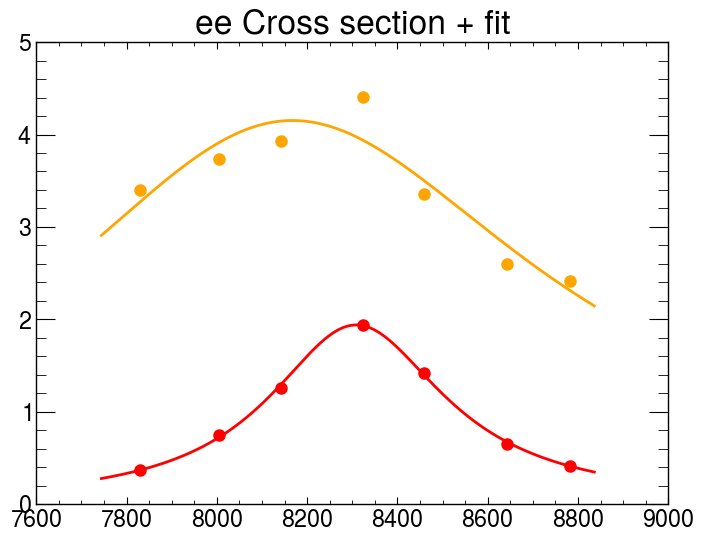

In [37]:
plt.title('ee Cross section + fit')
plt.plot(lumi_matrix[:,0]**2,cross_matrix[1],ls="",marker="o",color="orange")
plt.plot(s,breit_wigner(s,*popt[1]),color="orange")
plt.plot(lumi_matrix[:,0]**2,cross_matrix[2],ls="",marker="o",color="red")
plt.plot(s,breit_wigner(s,*popt[2]),color="red")

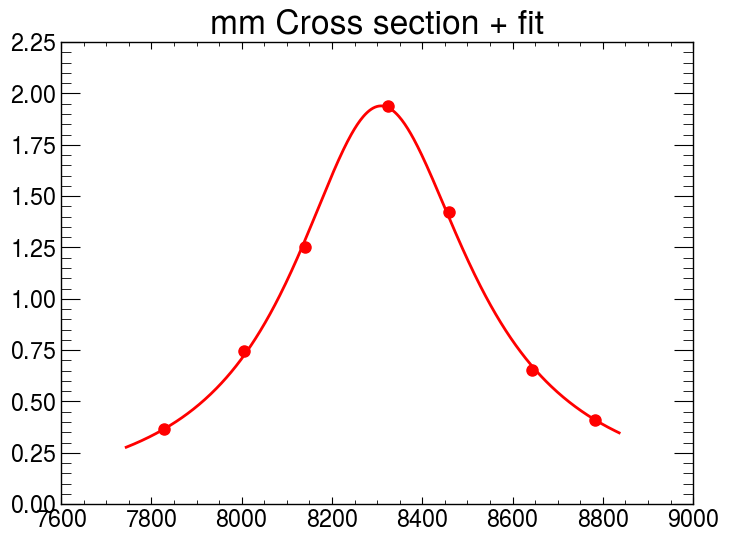

In [38]:

plt.title('mm Cross section + fit')
plt.plot(lumi_matrix[:,0]**2,cross_matrix[2],ls="",marker="o",color="red")
plt.plot(s,breit_wigner(s,*popt[2]),color="red")

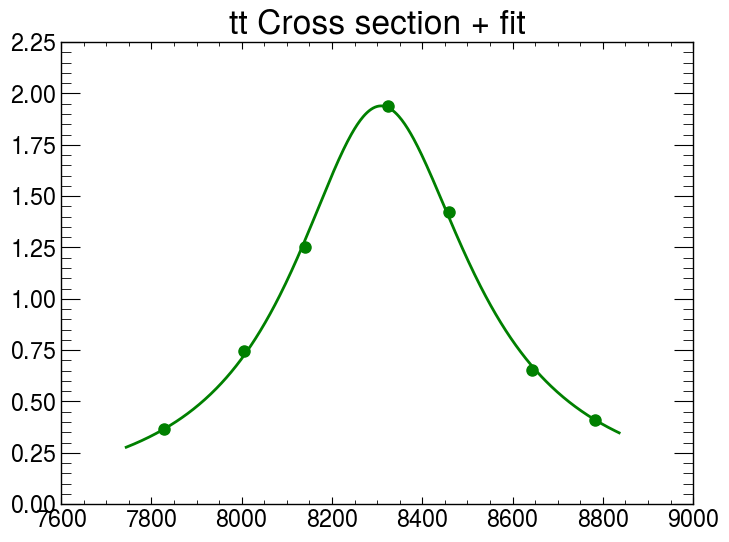

In [39]:

plt.title('tt Cross section + fit')
plt.plot(lumi_matrix[:,0]**2,cross_matrix[2],ls="",marker="o",color="green")
plt.plot(s,breit_wigner(s,*popt[2]),color="green")

## Revisite the s and t channel ratio for our real data set

(array([ 137.,  374.,  283.,  209.,  179.,  173.,  194.,  194.,  201.,
         172.,  212.,  162.,  141.,  172.,  167.,  174.,  169.,  187.,
         164.,  155.,  170.,  153.,  156.,  167.,  148.,  133.,  136.,
         143.,  140.,  140.,  122.,  125.,  129.,  127.,  113.,  130.,
         132.,  112.,  113.,  109.,  140.,  123.,  132.,  135.,  133.,
         118.,  115.,  123.,  121.,  121.,  150.,  120.,  131.,  136.,
         137.,  134.,  129.,  145.,  122.,  108.,  118.,  133.,  119.,
         147.,  144.,  140.,  127.,  134.,  149.,  146.,  153.,  164.,
         133.,  159.,  155.,  165.,  176.,  179.,  187.,  182.,  184.,
         217.,  214.,  235.,  217.,  227.,  241.,  258.,  306.,  314.,
         341.,  388.,  462.,  558.,  708.,  740.,  727., 1027.,  638.,
         147.]),
 array([-1.  , -0.98, -0.96, -0.94, -0.92, -0.9 , -0.88, -0.86, -0.84,
        -0.82, -0.8 , -0.78, -0.76, -0.74, -0.72, -0.7 , -0.68, -0.66,
        -0.64, -0.62, -0.6 , -0.58, -0.56, -0.54, -0.52, -0.

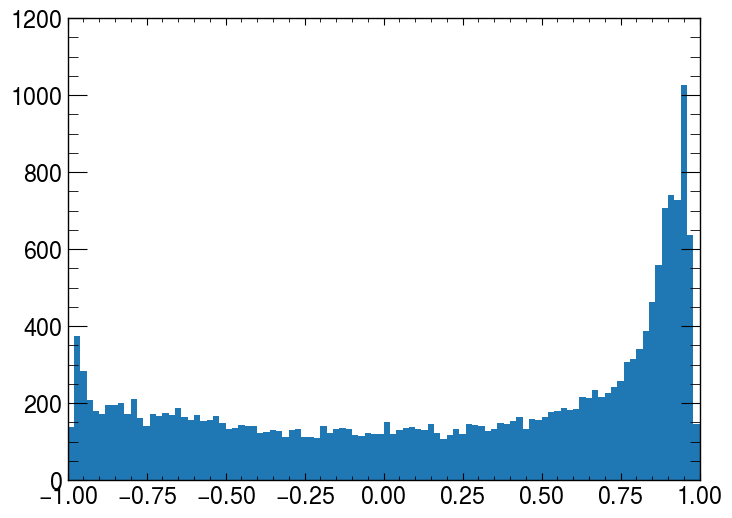

In [27]:
plt.hist(data_cos,bins=100,range=(-1,1))

Ratio: 0.8200985942211408


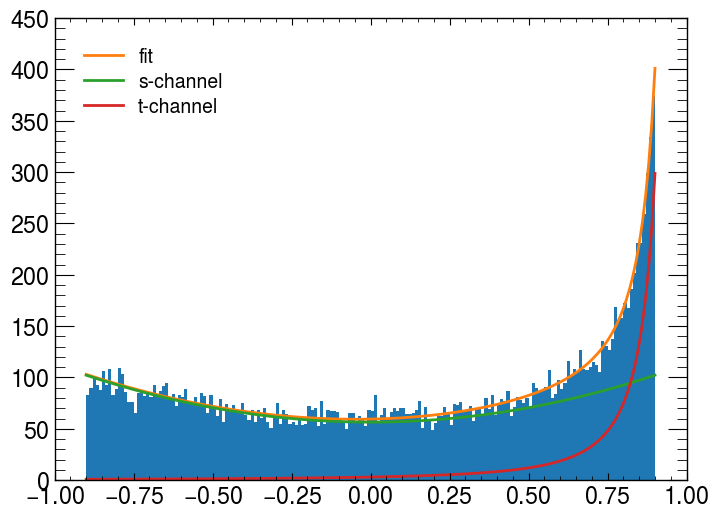

In [28]:
def fits(x,a,b):
    return a*(1+x**2) +b*(1-x)**(-2)

angles2 = np.linspace(-0.9,0.9,181)
new_bin_content, new_bin_edges,_ =plt.hist(data_cos,angles2)
new_mid = 0.5*(new_bin_edges[1:] + new_bin_edges[:-1])


coeff, var_matrix = curve_fit(fits, new_mid, new_bin_content)

#print("Coefficience a - b:",coeff)
#print("Var Matricies:",var_matrix)

plt.plot(angles2,fits(angles2,*coeff),label="fit")
plt.plot(angles2,coeff[0]*(1+angles2**2),label="s-channel")
plt.plot(angles2,coeff[1]*(1-angles2)**(-2),label="t-channel")
plt.legend()

def s(x):
    return coeff[0]*(1+x**2) 
def t(x):
    return coeff[1]*(1-x)**(-2) 

s_sum = integrate.quad(s,-0.9,0.9)[0]
t_sum = integrate.quad(t,-0.9,0.9)[0]

print("Ratio:",s_sum/(s_sum+t_sum))

In [29]:
energy1 = [] #88.48021
energy2 = [] #89.47158
energy3 = [] #90.2272
energy4 = [] #91.23223
energy5 = [] #91.97109
energy6 = [] #92.97091
energy7 = [] #93.71841

#energy_list,data_cos
#list(set(energy_list))

for i in range(len(energy_list)):
    if energy_list[i] == 88.48021:
        energy1.append(data_cos[i])
    elif energy_list[i] == 89.47158:
        energy2.append(data_cos[i])
    elif energy_list[i] == 90.2272:
        energy3.append(data_cos[i])
    elif energy_list[i] == 91.23223:
        energy4.append(data_cos[i])
    elif energy_list[i] == 91.97109:
        energy5.append(data_cos[i])
    elif energy_list[i] == 92.97091:
        energy6.append(data_cos[i])
    elif energy_list[i] == 93.71841:
        energy7.append(data_cos[i])
    else:
        print("Oops")
        break

(array([0.851394  , 1.70278293, 0.92879346, 0.77399455, 0.3095969 ,
        0.30959782, 0.38699727, 0.38699612, 0.54179618, 0.46439673,
        0.38699612, 0.23219836, 0.15479891, 0.23219836, 0.50309496,
        0.34829755, 0.30959782, 0.50309496, 0.27089809, 0.19349864,
        0.23219767, 0.30959782, 0.23219836, 0.42569573, 0.23219836,
        0.46439604, 0.27089809, 0.11609901, 0.27089769, 0.19349864,
        0.19349835, 0.30959782, 0.19349835, 0.3869967 , 0.34829755,
        0.3869967 , 0.23219802, 0.23219819, 0.15479879, 0.30959759,
        0.34829729, 0.30959736, 0.23219819, 0.30959747, 0.30959759,
        0.34829716, 0.23219815, 0.30959753, 0.19349846, 0.07739938,
        0.4643963 , 0.23219815, 0.34829722, 0.27089784, 0.19349842,
        0.27089789, 0.19349842, 0.19349849, 0.27089769, 0.34829729,
        0.23219819, 0.1160991 , 0.23219819, 0.19349835, 0.27089769,
        0.23219836, 0.30959736, 0.27089769, 0.23219836, 0.27089769,
        0.425697  , 0.27089769, 0.27089769, 0.38

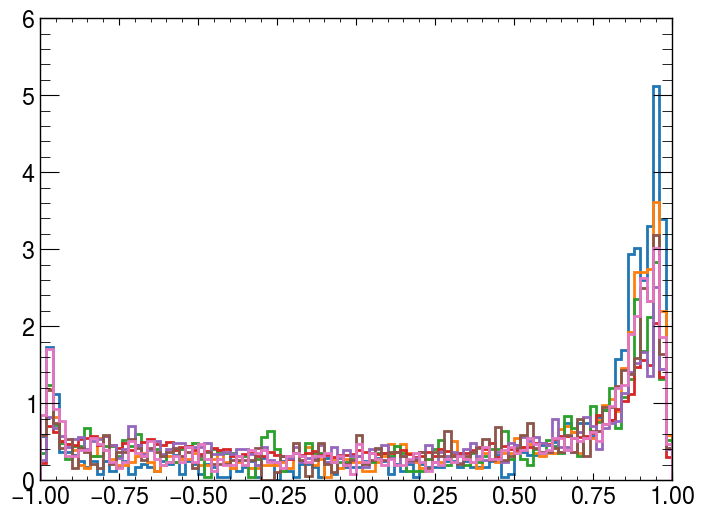

In [30]:
plt.hist(energy1,bins=100,range=(-1,1),density=True,histtype='step',  linewidth=2 )
plt.hist(energy2,bins=100,range=(-1,1),density=True,histtype='step',  linewidth=2  )
plt.hist(energy3,bins=100,range=(-1,1),density=True,histtype='step',  linewidth=2)
plt.hist(energy4,bins=100,range=(-1,1),density=True,histtype='step',  linewidth=2)
plt.hist(energy5,bins=100,range=(-1,1),density=True,histtype='step',  linewidth=2)
plt.hist(energy6,bins=100,range=(-1,1),density=True,histtype='step',  linewidth=2)
plt.hist(energy7,bins=100,range=(-1,1),density=True,histtype='step',  linewidth=2)

In [31]:
len(energy_list)

175883